In [1]:
import psycopg2
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import statsmodels.api as sm
from statsmodels.formula.api import ols
from distfit import distfit
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa import forecasting
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import acf
from scipy.stats import bootstrap
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df1 = pd.read_csv('grades_history_trimmed.csv')
df2 = pd.read_csv('grades_trimmed.csv')

df1_1 = df1.drop(['Unnamed: 0', 'id', 'oldid', 'source', 'loggeduser', 'rawscaleid', 'usermodified',
                  'finalgrade', 'overriden', 'feedback', 'feedbackformat',
                  'year_month', 'action', 'grade_cat'], axis=1)
df2_2 = df2.drop(['Unnamed: 0', 'id', 'rawscaleid', 'usermodified', 'agreegationstatus',
                  'finalgrade', 'overriden', 'feedback', 'feedbackformat',
                  'agreegationweight', 'time_created', 'grade_cat', 'timecreated'], axis=1)

df1_1 = df1_1.reindex(sorted(df1_1.columns), axis=1)
df2_2 = df2_2.reindex(sorted(df2_2.columns), axis=1)
df = pd.concat([df1_1, df2_2])

In [4]:
conn = psycopg2.connect(dbname='primuss_fhin',
                            user='thisuccess',
                            password='5N7vcG!8FD%',
                            host='194.94.97.25',
                            port='8890')

cur = conn.cursor()
cur.execute("SELECT * FROM moodle.mdl21_grade_items")

records = cur.fetchall()

cur.close()
conn.close()

headers = ['id', 'courseid', 'categoryid', 'itemname', 'itemtype', 'itemmodule', 'iteminstance', 'itemnumber',
           'iteminfo', 'idnumber', 'calculation', 'gradetype', 'grademax', 'grademin', 'scaleid',
           'outcomeid', 'gradepass', 'multfactor', 'plusfactor', 'aggregationcoef', 'sortorder', 'display',
           'decimals', 'hidden', 'locked', 'locktime', 'needsupdate',
           'timecreated', 'timemodified', 'aggregationcoef2', 'weightoverride']

grade_items = pd.DataFrame(records, columns = headers)
grade_items = grade_items.reset_index()

In [5]:
course_dict = {grade_items['id'][i]:grade_items['courseid'][i] for i in range(len(grade_items))}
df['course'] = df['itemid'].replace(course_dict)

In [6]:
df.head()

,grade,itemid,month,rawgrade,rawgrademax,rawgrademin,time_modified,timemodified,userid,year,year_norm,course
0,96.06060,2640,1.0,9.60606,10.0,0.0,2016-01-16 13:38:57,1.452952e+09,6816,2016.0,0.0,222
1,61.42857,5046,1.0,61.42857,100.0,0.0,2016-01-16 13:49:27,1.452952e+09,866,2016.0,0.0,5046
2,91.42857,3540,1.0,91.42857,100.0,0.0,2016-01-16 16:45:30,1.452963e+09,9394,2016.0,2.0,1055
3,88.76810,3541,1.0,8.87681,10.0,0.0,2016-01-16 17:14:26,1.452964e+09,9394,2016.0,2.0,1055
4,96.20690,2641,1.0,9.62069,10.0,0.0,2016-01-16 18:09:13,1.452968e+09,6816,2016.0,0.0,222


In [7]:
def UserReindex(df = df, userid = 'userid'):
    if isinstance(df, pd.DataFrame):
        df_n = df.sort_values('userid', inplace=True)
        df_n = df.reset_index()
        user = df_n['userid'].to_list()
        from itertools import accumulate
        indexes  = range(len(user))
        byGroup  = accumulate(indexes,lambda i,u: (i+1)*(u>0 and user[u-1]==user[u]))
        indexes  = [i-1 for i in accumulate(int(g==0) for g in byGroup)]
        indexAndUser = [(i,u) for i,u in zip(indexes,user)]
        new_user = pd.DataFrame([(i,u) for i,u in zip(indexes,user)], columns=['new_user', 'old_user'])

        df_n['userid_n'] = new_user['new_user']
        df_n = df_n.drop('index', axis=1)
        return df_n
    else:
        raise TypeError('The imported object is not a pandas.DataFrame. Please import a pandas.DataFrame type.')

In [8]:
def bootstrap(data, samples=500, sample_size=500, stat='nostat'):
    my_samples = []
    for _ in range(samples):
        x = np.random.choice(data, size=sample_size, replace=True)
        if stat=='median':
            my_samples.append(np.median(x))
        elif stat=='nostat':
            my_samples.append(np.random.choice(x))
        else:
            my_samples.append(x.mean())
    return pd.Series(my_samples)

In [9]:
from tqdm import tqdm
print(df.columns)
user_df = df[['grade', 'itemid', 'time_modified', 'timemodified', 'userid', 'year', 'course']]

user_df = df.sort_values('time_modified', ascending=True).groupby('userid')    

all_dataframes = []
all_dataframes_grades = []
user_df = df[['grade', 'itemid', 'time_modified', 'timemodified', 'userid', 'year', 'course']]

user_df = user_df.sort_values('time_modified', ascending=True).groupby('userid') 
rg = user_df.size().max()-1

for i in tqdm(range(rg)):
    current_df = pd.DataFrame(columns=['grade', 'itemid', 'time_modified', 'timemodified', 'userid', 'year', 'course'])    
    for x in user_df.groups:
        if len(user_df.get_group(x))>i:
            n = pd.DataFrame(user_df.get_group(x))
            a = n.iloc[[i]]
            current_df = current_df.append(a, ignore_index=True)
    all_dataframes.append(current_df)
    all_dataframes_grades.append(current_df['grade'])

Index(['grade', 'itemid', 'month', 'rawgrade', 'rawgrademax', 'rawgrademin',
       'time_modified', 'timemodified', 'userid', 'year', 'year_norm',
       'course'],
      dtype='object')


100%|██████████| 137/137 [03:54<00:00,  1.71s/it]


In [10]:
# Student Simulator version 2.1
import random
def StudentSimulator(df, size, method, userid = 'userid', seed = 123, add_method = 'reuse'):
    
    np.random.seed(seed)
    vector = np.vectorize(np.int_)
    
    #Create the df
    data = pd.DataFrame(columns=["id", "userid", "quizid", "courseid", "time_used", "grade"])

    #Adding idx
    data['id'] = list(range(1,size+1))
    
    #Adding userid
    if add_method == 'reuse':
        #Creating the output dataframe
        newdf = pd.DataFrame()

        #Gather the unique users
        users = df[userid].unique()

        #Simulate students and reindexing
        ids = np.array(range(1, size+1))
        newuserid = []
        counter = 0

        while len(newdf) <= size:
            counter += 1
            user = int(np.random.choice(users, 1))
            t = df[userid]==user
            newdf = newdf.append(df[t]) 
            newuserid.append([counter]*t.sum())

        newuserid = [item for sublist in newuserid for item in sublist]
        newdf[userid] = newuserid

        newdf = newdf.reset_index()

        #Random remove the excess amount of observations 
        if len(newdf) > size:
            remove_n = len(newdf) - size
            drop_indices = np.random.choice(newdf.index, remove_n, replace=False)
            newdf1 = newdf.drop(drop_indices)
            
        users = newdf1['userid'].to_list()
        courses = newdf1['course'].to_list()
        items = newdf1['itemid'].to_list()
        data['userid'] = users
        data['courseid'] = courses
        data['quizid'] = items
        
        #check_nan = data['userid'].isnull().values.any()
        #print(check_nan)
        #check_nan = data['courseid'].isnull().values.any()
        #print(check_nan)
        #check_nan = data['quizid'].isnull().values.any()
        #print(check_nan)
     
    elif add_method == 'simulate':
        df = UserReindex(df = df, userid = userid)
        uniques = int(size*df['userid_n'].nunique()/len(df))
        sampler = vector(np.linspace(start=1, stop=uniques, num=uniques))
        
        users = df['userid_n'].value_counts().rename_axis('userid').reset_index(name='counts')
        users_count = users['counts'].value_counts().rename_axis('no_of_grades').reset_index(name='no_of_students') 
        users_count = users_count.sort_values('no_of_grades')

        prob = stats.pareto.rvs(size=uniques, b=1.86, loc=-6.788, scale=7.788, random_state=seed)
        prob /= np.sum(prob)

        sampled_users = pd.Series(np.random.choice(sampler, size, p=prob))    
        data['userid'] = sampled_users

        #Adding courseid
        uniques = int(size*df['course'].nunique()/len(df))
        sampler = vector(np.linspace(start=1, stop=uniques, num=uniques))

        courses = df['course'].value_counts().rename_axis('courseid').reset_index(name='counts')
        courses_count = courses['counts'].value_counts().rename_axis('no_of_grades').reset_index(name='no_of_courses') 
        courses_count = courses_count.sort_values('no_of_grades')

        prob = stats.expon.rvs(size=uniques, loc=1, scale=58.928, random_state=seed)
        prob /= np.sum(prob)

        sampled_courses = pd.Series(np.random.choice(sampler, size, p=prob))    
        data['courseid'] = sampled_courses    

        #Adding items

        items = list(range(1, size+1))
        sampled_items = []
        data = data.sort_values('courseid')
        for i in tqdm(data['courseid'].unique(), desc='Finding quizzes'):
            myitems = [items.pop(random.randrange(len(items))) for _ in range(int(max(1, 0.15*len(data[data['courseid']==i]))))]
            sampled_items.append([random.choice(myitems) for _ in range(len(data[data['courseid']==i]))])

        data['quizid'] = sum(sampled_items, [])  

    #Adding time
    time=stats.lognorm.rvs(s=1.22, loc=-10.20, scale=389.70, size=size)
    data['time_used'] = time
    
    #Adding grades

    sampled_grades = []
    sampled_grades1 = []
    all_dataframes1 = []
    all_dataframes1_grades = []
    
    data = data.sample(frac=1).reset_index(drop=True)
    
    user_df = data[["id", "userid", "quizid", "courseid", "time_used", "grade"]]

    user_df = user_df.groupby('userid') 
    rg1 = user_df.size().max()
    
    for i in tqdm(range(rg1), desc='Finding grades'):
        current_df = pd.DataFrame(columns=["id", "userid", "quizid", "courseid", "time_used", "grade"])    
        for x in user_df.groups:
            if len(user_df.get_group(x))>i:
                n = pd.DataFrame(user_df.get_group(x))
                a = n.iloc[[i]]
                current_df = current_df.append(a, ignore_index=True)
        all_dataframes1.append(current_df)
        all_dataframes1_grades.append(current_df['grade'])
    a = []
    for i in tqdm(range(len(all_dataframes_grades)), desc='Saving grades'):
        if i >= 1:
            for j in range(len(all_dataframes1_grades)):
                #all_dataframes1_grades[j] = all_dataframes1_grades[j].to_list()
                #print(all_dataframes1_grades)
                if method == 'random':
                    if i <= j:
                        for k in range(len(all_dataframes1_grades[j])):
                            all_dataframes1_grades[j][k] = np.random.choice(bootstrap(all_dataframes_grades[i], sample_size=10, samples=10))
                    else:
                        for k in range(len(all_dataframes1_grades[j])):
                            a = np.array(range(i))
                            all_dataframes1_grades[j][k] = np.random.choice(bootstrap(all_dataframes_grades[np.random.choice(a)], sample_size=10, samples=10)) 
                elif method == 'half_random':
                    if i <= j:
                        for k in range(len(all_dataframes1_grades[j])):
                            all_dataframes1_grades[j][k] = bootstrap(all_dataframes_grades[i], sample_size=10, samples=10).median()
                    else:
                        for k in range(len(all_dataframes1_grades[j])):
                            a = np.array(range(i))
                            all_dataframes1_grades[j][k] = bootstrap(all_dataframes_grades[np.random.choice(a)], sample_size=10, samples=10).median()
    for i in range(len(all_dataframes1)):
        all_dataframes1[i]['grade'] = all_dataframes1[i]['grade'].append(all_dataframes1_grades[i], ignore_index=True)
    data = pd.concat(all_dataframes1)
    data['grade'] = data['grade'] + np.random.normal(0, 3, len(data['grade']))
    data = data.sample(frac=1).reset_index(drop=True)
    
    data['grade'].where(data['grade']<100, 100, inplace=True)
    data['grade'].where(data['grade']>=0, 0, inplace=True)
    
    return data


In [17]:
x = StudentSimulator(df, 1000, method = 'half_random', add_method='reuse')

Saving grades: 100%|██████████| 137/137 [01:21<00:00,  1.68it/s]


In [18]:
x.head()

,id,userid,quizid,courseid,time_used,grade
0,296,40,15266,15266,953.609157,87.428817
1,674,87,2479,1537,256.371268,85.481074
2,605,78,6599,563,1185.176458,71.393081
3,298,40,15629,15629,497.041973,66.219495
4,378,46,6474,1097,885.504152,79.16065


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm     ] [0.00 sec] [RSS: 0.000945533] [loc=69.364 scale=16.611]
[distfit] >[beta     ] [0.05 sec] [RSS: 0.0107838] [loc=-13.984 scale=0.000]
[distfit] >[lognorm  ] [0.04 sec] [RSS: 0.0204265] [loc=0.417 scale=1.395]
[distfit] >[gamma    ] [0.04 sec] [RSS: 0.0011869] [loc=-185.765 scale=1.202]
[distfit] >[loggamma ] [0.01 sec] [RSS: 0.000254492] [loc=78.905 scale=11.090]
[distfit] >[cauchy   ] [0.00 sec] [RSS: 0.00101679] [loc=73.064 scale=8.261]
[distfit] >[chi      ] [0.05 sec] [RSS: 0.00101531] [loc=-420.510 scale=24.012]
[distfit] >[uniform  ] [0.00 sec] [RSS: 0.00574182] [loc=0.417 scale=99.583]
[distfit] >[chi2     ] [0.05 sec] [RSS: 0.00124455] [loc=-154.786 scale=0.711]
[distfit] >[dgamma   ] [0.01 sec] [RSS: 0.000523769] [loc=71.607 scale=9.504]
[distfit] >[expon    ] [0.00 sec] [RSS: 0.00868268] [loc=0.417 scale=68.947]
[distfit] >[exponnorm] [0.01 sec] [RSS: 0.000945534] [loc=69.353 scale=16.611]
[distfit] >[t        ] [0

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot: title={'center': '\nloggamma\nRSS(c=0.847615, loc=78.9048, scale=11.0904)'}, xlabel='Values', ylabel='Frequency'>)

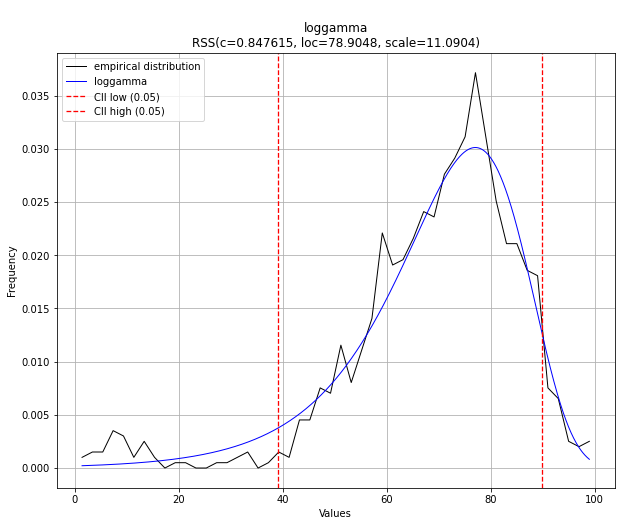

In [19]:
# Half-random
distr = ['norm', 'beta', 'lognorm', 'gamma', 'loggamma', 'cauchy', 'chi', 'uniform', 'chi2', 'dgamma', 
        'expon', 'exponnorm', 't', 'pareto', 'logistic']
dist = distfit(distr=distr)
# Fit on data
results = dist.fit_transform(x['grade'])
dist.plot()

In [20]:
x = StudentSimulator(df, 10000, method = 'random')

Saving grades: 100%|██████████| 137/137 [11:23<00:00,  4.99s/it]


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm     ] [0.00 sec] [RSS: 0.00150726] [loc=65.113 scale=26.418]
[distfit] >[beta     ] [0.12 sec] [RSS: 0.00152153] [loc=-10.355 scale=110.355]
[distfit] >[lognorm  ] [0.24 sec] [RSS: 0.0015395] [loc=-5913.578 scale=5978.417]
[distfit] >[gamma    ] [0.09 sec] [RSS: 0.0016626] [loc=-313.227 scale=1.989]
[distfit] >[loggamma ] [0.02 sec] [RSS: 0.000201765] [loc=97.000 scale=3.902]
[distfit] >[cauchy   ] [0.01 sec] [RSS: 0.00124292] [loc=75.724 scale=14.716]
[distfit] >[chi      ] [0.10 sec] [RSS: 0.00217931] [loc=-1.525 scale=63.892]
[distfit] >[uniform  ] [0.00 sec] [RSS: 0.00183145] [loc=0.000 scale=100.000]
[distfit] >[chi2     ] [0.12 sec] [RSS: 0.018435] [loc=-0.000 scale=7.176]
[distfit] >[dgamma   ] [0.03 sec] [RSS: 0.00130805] [loc=68.778 scale=14.183]
[distfit] >[expon    ] [0.00 sec] [RSS: 0.00430693] [loc=0.000 scale=65.113]
[distfit] >[exponnorm] [0.05 sec] [RSS: 0.00150726] [loc=65.094 scale=26.418]
[distfit] >[t        ]

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot: title={'center': '\nloggamma\nRSS(c=0.128406, loc=96.9996, scale=3.90219)'}, xlabel='Values', ylabel='Frequency'>)

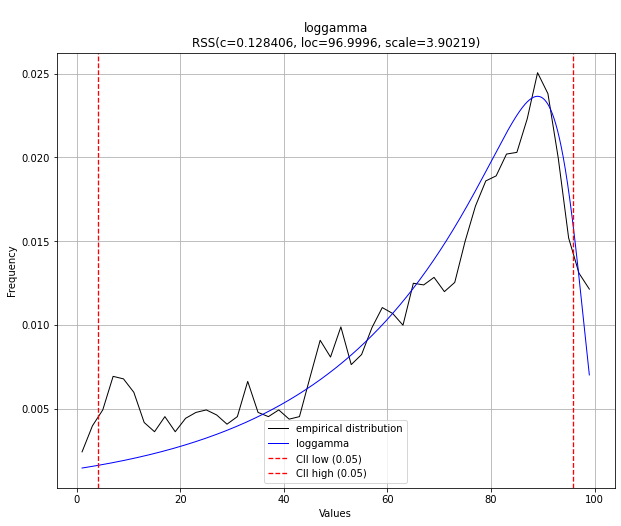

In [21]:
# Random
distr = ['norm', 'beta', 'lognorm', 'gamma', 'loggamma', 'cauchy', 'chi', 'uniform', 'chi2', 'dgamma', 
        'expon', 'exponnorm', 't', 'pareto', 'logistic']
dist = distfit(distr=distr)
# Fit on data
results = dist.fit_transform(x['grade'])
dist.plot()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm     ] [0.00 sec] [RSS: 0.00282428] [loc=69.469 scale=24.005]
[distfit] >[beta     ] [0.75 sec] [RSS: 0.00150178] [loc=-12.579 scale=112.553]
[distfit] >[lognorm  ] [1.68 sec] [RSS: 0.00283692] [loc=-6805.345 scale=6874.799]
[distfit] >[gamma    ] [0.65 sec] [RSS: 0.00314485] [loc=-161.316 scale=2.920]
[distfit] >[loggamma ] [0.18 sec] [RSS: 0.00118246] [loc=97.941 scale=1.911]
[distfit] >[cauchy   ] [0.06 sec] [RSS: 0.00240317] [loc=79.091 scale=12.510]
[distfit] >[chi      ] [0.66 sec] [RSS: 0.00649741] [loc=-260.809 scale=191.901]
[distfit] >[uniform  ] [0.00 sec] [RSS: 0.00399732] [loc=0.001 scale=99.973]
[distfit] >[chi2     ] [0.66 sec] [RSS: 0.00313435] [loc=-185.279 scale=1.279]
[distfit] >[dgamma   ] [0.23 sec] [RSS: 0.00265879] [loc=71.825 scale=12.421]
[distfit] >[expon    ] [0.00 sec] [RSS: 0.00674907] [loc=0.001 scale=69.468]
[distfit] >[exponnorm] [0.52 sec] [RSS: 0.0028243] [loc=69.452 scale=24.005]
[distfit] >[t   

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot: title={'center': '\nloggamma\nRSS(c=0.069284, loc=97.9413, scale=1.91062)'}, xlabel='Values', ylabel='Frequency'>)

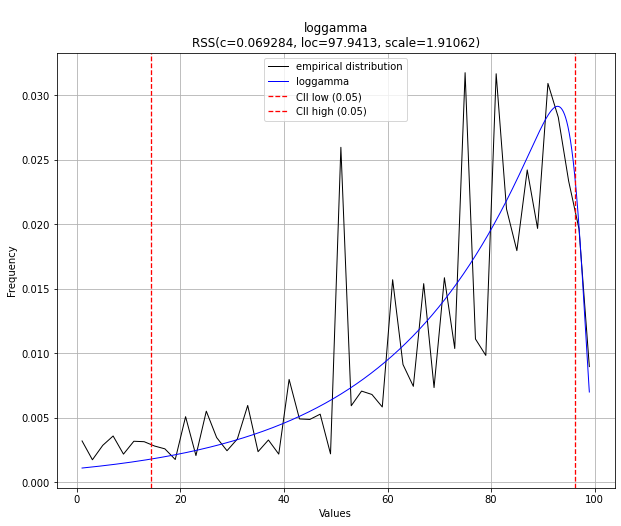

In [22]:
# Real
dist = distfit(distr=distr)
# Fit on data
results = dist.fit_transform(df['grade'])
dist.plot()

In [11]:
simdata = StudentSimulator(df, 100000, method = 'half_random', add_method='reuse')

Finding grades:   2%|▏         | 3/138 [02:02<1:25:21, 37.94s/it]

Saving grades: 100%|██████████| 137/137 [2:07:49<00:00, 55.98s/it] 


In [12]:
simdata.head()

,id,userid,quizid,courseid,time_used,grade
0,10920,1224,2330,1537,3643.045725,58.473188
1,62802,7237,24136,7597,1230.720675,73.672204
2,76219,8733,23120,23120,496.518184,81.418872
3,11764,1328,2480,1537,2381.252742,65.665842
4,58578,6697,12049,12049,87.162759,91.313768


In [13]:
user_df = simdata.groupby('userid')    
 
rg = user_df.size().max()-1
all_dataframes = []
for i in tqdm(range(rg)):
    current_df = pd.DataFrame(columns=['id', 'userid', 'quizid', 'courseid', 'time_used', 'grade'])    
    for x in user_df.groups:
        if len(user_df.get_group(x))>i:
            n = pd.DataFrame(user_df.get_group(x))
            a = n.iloc[[i]]
            current_df = current_df.append(a, ignore_index=True)
    all_dataframes.append(current_df)
    #all_datframes_grades.append(current_df['grade'])

  0%|          | 0/137 [00:00<?, ?it/s]

100%|██████████| 137/137 [02:54<00:00,  1.27s/it]


In [14]:
import statsmodels.stats.api as sms
avg = []
std = []
ci_l = []
ci_u = []
for i in range(len(all_dataframes)):
    avg.append(all_dataframes[i]['grade'].mean())
    std.append(all_dataframes[i]['grade'].std())
    ci_l.append(sms.DescrStatsW(all_dataframes[i]['grade']).tconfint_mean()[0])
    ci_u.append(sms.DescrStatsW(all_dataframes[i]['grade']).tconfint_mean()[1])
    stat = pd.DataFrame({'avg_grades':avg, 'std_grades':std, 'ci_low':ci_l, 'ci_up':ci_u})

In [15]:
stat['ci_low'].where(stat['ci_low'] >= 0, 0, inplace=True)
stat['ci_up'].where(stat['ci_up'] < 100, 100, inplace=True)

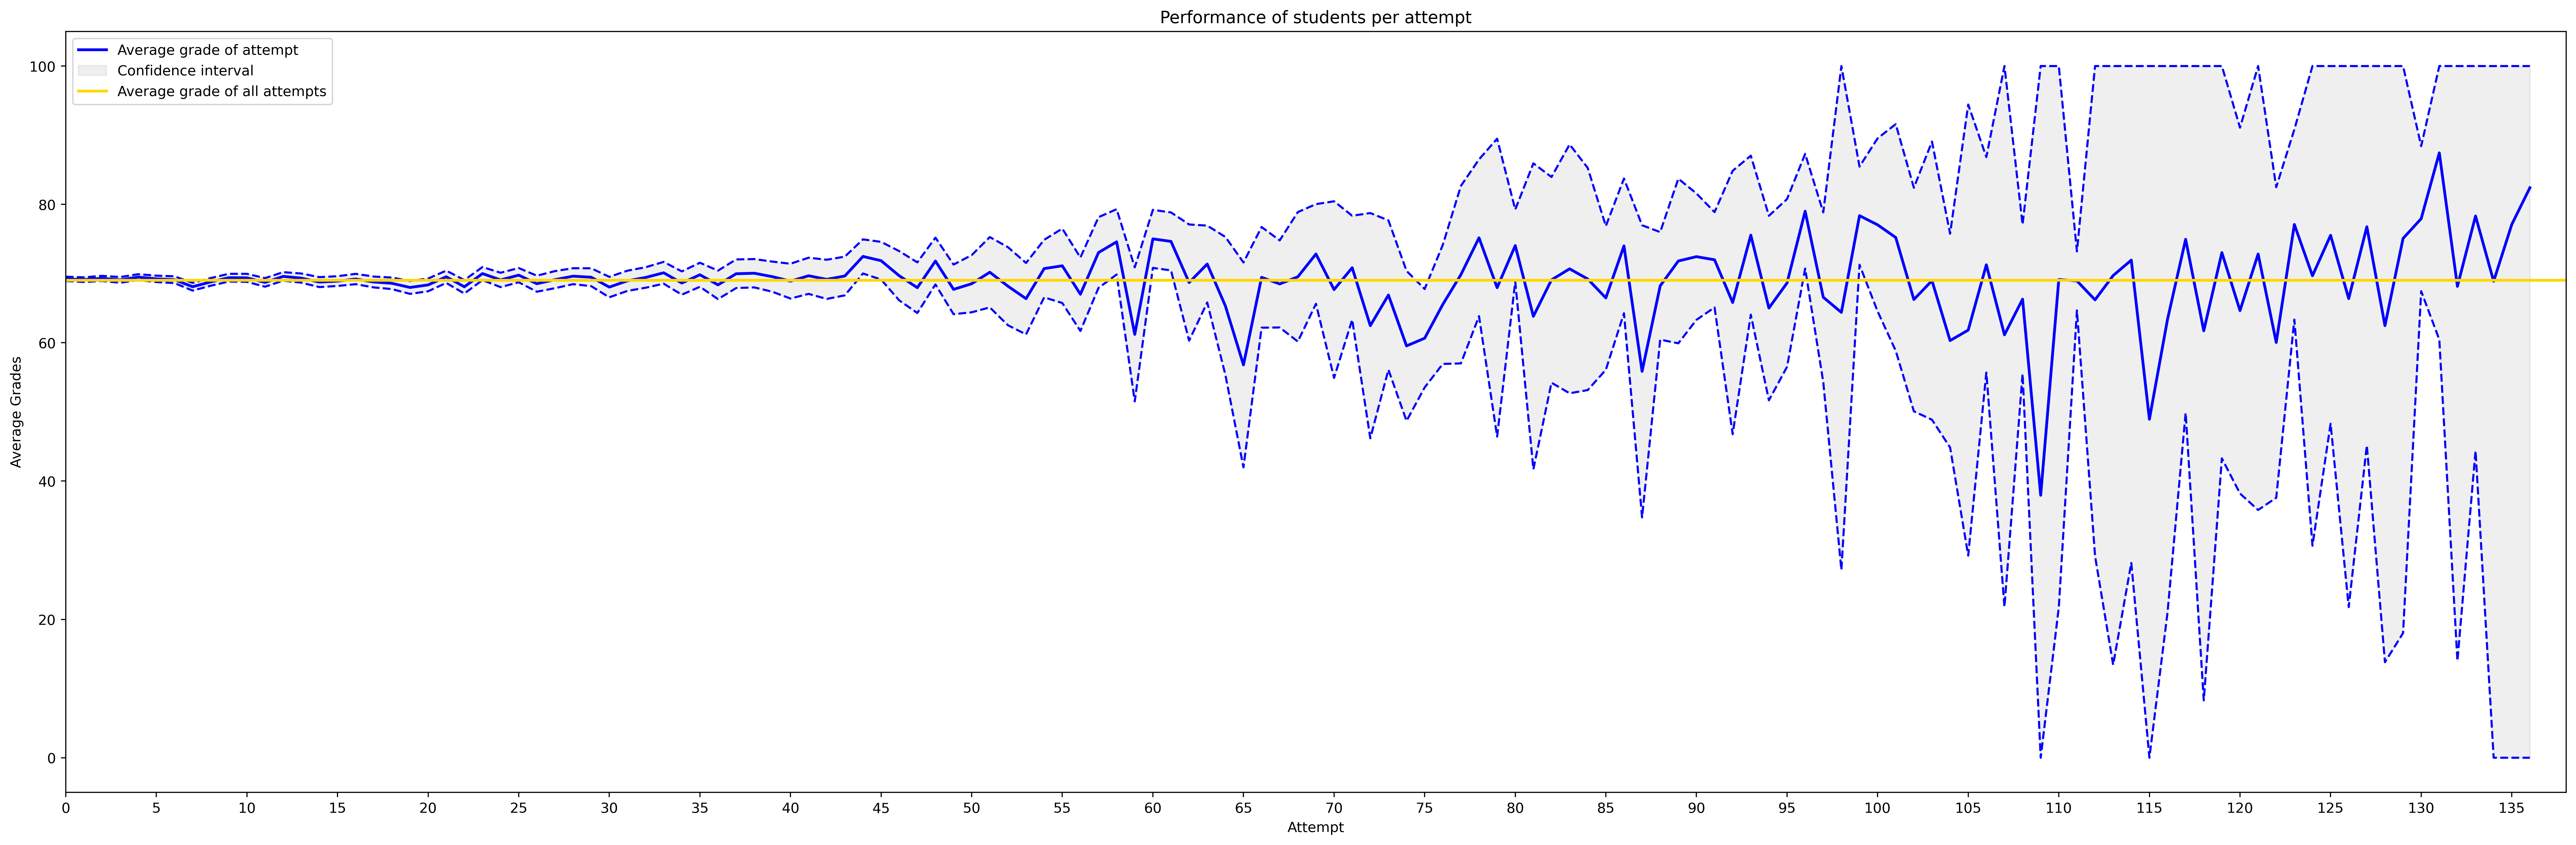

In [19]:
plt.figure(figsize=(32,10), dpi=400)
plt.xlim(0,138)
plt.plot(stat.index, stat['avg_grades'], color='blue', lw=2)
plt.plot(stat.index, stat['ci_low'], color='blue', linestyle="--", label='_nolegend_')
plt.plot(stat.index, stat['ci_up'], color='blue', linestyle="--", label='_nolegend_')
plt.fill_between(stat.index, stat['ci_low'], stat['ci_up'], color='dimgrey', alpha=0.1, animated=True)
plt.gca().set(title='Performance of students per attempt', xlabel='Attempt', ylabel='Average Grades')
plt.axhline(y=stat['avg_grades'].mean(), color='gold', lw=2)
plt.xticks(np.arange(0,138,5))
plt.legend(['Average grade of attempt', 'Confidence interval', 'Average grade of all attempts'], loc=2)
plt.show()

In [115]:
#### Test for simulated users ####


def test_sim(df, size, userid = 'userid'):
    #Create the df
    data = pd.DataFrame(columns=["id", "userid", "quizid", "attempts", "courseid", "time_used", "grade"])

    #Adding idx
    data['id'] = list(range(1,size+1))
    
    #Adding userid
    max_user = df[userid].value_counts().max()
    
    df = UserReindex(df = df, userid = userid)
    vector = np.vectorize(np.int_)
    uniques = int(size*df['userid_n'].nunique()/len(df))
    number_array = vector(np.linspace(start=1, stop=uniques, num=uniques))

    scale, loc = 7.79, -6.79
    pareto_scaled = scale * 1 / (x ** 1.86) + loc

    assigned_users = {}  # Dictionary to track the number of times a user is assigned
    random_numbers = []
    for _ in tqdm(range(size), desc='Adding users'):
        probabilities = np.array([pareto_scaled for x in number_array])  # Calculate probabilities using Pareto distribution
        probabilities /= np.sum(probabilities)  # Normalize probabilities to sum up to 1

        num = np.random.choice(number_array, p=probabilities)  # Choose a user from the array based on the probabilities

        # Check if the number has already been assigned the max times
        if num not in assigned_users or assigned_users[num] < max_user:
            random_numbers.append(num)  # Add the number to the list
            assigned_users[num] = assigned_users.get(num, 0) + 1  # Increment the count for the number

    # Create a Pandas Series from the list of random numbers
    series = pd.Series(random_numbers)
    data['userid'] = series
    print ('Max allowed users:', len(number_array))
    return data

In [116]:
test = test_sim(df, 102896)
test.head()

Adding users:   4%|▍         | 3964/102896 [00:03<01:33, 1061.60it/s]Adding users: 100%|██████████| 102896/102896 [01:37<00:00, 1055.59it/s]


Max allowed users: 11826


,id,userid,quizid,attempts,courseid,time_used,grade
0,1,2659,NaN,NaN,NaN,NaN,NaN
1,2,7614,NaN,NaN,NaN,NaN,NaN
2,3,1205,NaN,NaN,NaN,NaN,NaN
3,4,2290,NaN,NaN,NaN,NaN,NaN
4,5,7216,NaN,NaN,NaN,NaN,NaN


In [117]:
print("Simulated:")
print("Uniques:", test['userid'].nunique(), "Number of steps:", test['userid'].value_counts().max(), "Length", len(test))
print("Real:")
print("Uniques:", df['userid'].nunique(), "Number of steps:", df['userid'].value_counts().max(), "Length", len(df))

Simulated:
Uniques: 11824 Number of steps: 24 Length 102896
Real:
Uniques: 11826 Number of steps: 138 Length 102896
